# word2vec and doc2vec by hand with NumPy
In this notebook, we will learn word and document vectors completely by hand on the IMDB movie review dataset, with just a `for` loop and NumPy! This is a great exercise for anyone wanting to make sure they have fully understood how word2vec and doc2vec works.
We will jointly implement the following models:
* word2vec's **skip-gram with negative sampling**, as introduced in [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781.pdf) and [Distributed Representations of Words and Phrases and their Compositionality](https://arxiv.org/pdf/1310.4546.pdf).
* doc2vec (a.k.a. Paragraph Vector)'s **distributed bag-of-words**, following [Distributed Representations of Sentences and Documents](https://arxiv.org/pdf/1405.4053.pdf).

We will also:

* write an **inference** function to compute the vector of any new document
* **visualize** word and document vectors separately, and together in the same space

I have summarized the math behind the models and curated relevant references in my [notes](https://arxiv.org/pdf/1808.09772.pdf). I encourage you to have a look at them if you're interested in the technical details.

** = = = ** *Special thanks to my labmate [JbRemy](https://github.com/JbRemy) who encouraged me to use only NumPy, checked my gradients and my code, gave me great NumPy tips, and introduced me to `tqdm`.* ** = = = ** 

**Other notebooks**: you may want to check out my Keras implementations of [1D CNN](https://github.com/Tixierae/deep_learning_NLP/blob/master/CNN_IMDB/cnn_imdb.ipynb) and [Hierarchical Attention Network](https://github.com/Tixierae/deep_learning_NLP/blob/master/HAN/HAN_final.ipynb) for sentiment analysis on the IMDB and Amazon datasets. The Amazon dataset is very big (3,6M reviews), but my implementation is fully RAM-friendly (including the preprocessing part), so, as long as you have a GPU, you're good to go.


## Preprocessing
Before doing anything, we need to clean our documents.
Then, each document has to be converted into a list of integers that correspond to indexes in our vocabulary.
In that vocabulary, the most frequent word has index 1 and only the words that appear a least a certain number of times are kept.
The other words are replaced by 0, which is the index for out-of-vocabulary words.
These steps are implemented in the [preprocessing.py](https://github.com/Tixierae/deep_learning_NLP/blob/master/skipgram/preprocessing.py) script.

The raw and preprocessed data should be downloaded from [here](https://www.dropbox.com/s/vrlpj6qhxmit5bg/data.zip?dl=0) and the files put in the `/data/` subdirectory.

## Objective
I provide a brief overview of how skip-gram works below.

* skip-gram is trained on an artificial **context prediction** task: we ask the model, given a word, to predict the words surrounding it. This task does not require any kind of annotations, just large amounts of text. The word vectors are the parameters of the model, so they are obtained as a by-product of training. Each word has two representations, stored respectively in matrices $W_t \in \mathbb{R}^{|V|\times d}$ and $W_c \in \mathbb{R}^{d \times |V|}$, where $V$ is the vocab and $d$ the dimensionality of the word embedding space. Depending on whether a given word is used as target or context, we will draw its representation from $W_t$ or $W_c$. These two matrices are often referred to as the *input* and *output* matrices, and usually, the input matrix (after training) is used as the word embeddings.
* pairs of target and context words $(t,\mathcal{C}_t)$ are sampled by **sliding a window** over the training corpus $\{0,1,\dots,T\}$. For a given instantiation of the window, the word in the middle is the target word $t$, and the words surrounding it compose the set of positive examples $\mathcal{C}_t$.
* the window size is **dynamic** (uniformly sampled in $[1,max\_window\_size]$).

The objective of skip-gram is to predict the context words $\mathcal{C}_t$ given the target word $t$. For a given prediction, rather than trying to assign a probability to each single word in the vocabulary with a softmax, which is very expensive, we ask the model to perform a **binary discrimination task** with a sigmoid.
More precisely, we teach the model to distinguish between words from the true context $\mathcal{C}_t^+$ of a given target word (i.e., the other words from the window) and negative examples $\mathcal{C}_t^-$, sampled at random from the vocabulary. This is the **negative sampling** trick. What I've just described can be translated into the following objective:

\begin{equation}
\arg\min_\theta \sum_{t=1}^T \Big( \sum_{c \in \mathcal{C}_t^+ } \log \big(1+e^{-w_c \cdot w_t}\big) + \sum_{c \in \mathcal{C}_t^-} \log \big(1+e^{w_c \cdot w_t}\big) \Big)
\end{equation}

To minimize that log likelihood over the corpus, we want word vectors such that the similarity (dot product) between each target word's vector and its positive/negative examples' vectors is as high/low as possible.

## Document vectors
Keep in mind we want to learn document vectors jointly with the word vectors. To do that, we have several options:

* 1) one way is to follow the first idea presented in the [doc2vec](https://arxiv.org/pdf/1310.4546.pdf) paper, and combine (via averaring) a document vector to the target word vector before performing the discrimination tasks. This variant of doc2vec is called **distributed memory**<sup>1</sup>.

* 2) another way is to not have target words anymore, and just predict context words from the document vectors. This variant is called **distributed bag-of-words** in the paper. We would still be learning word vectors through upadting the $W_c$ matrix. The quality of the vectors would probably suffer though, since they would interact only with the document vectors, not other word vectors.

* 3) yet another way is to follow what the gensim folks do [see here](https://stackoverflow.com/questions/44011706/what-is-different-between-doc2vec-models-when-the-dbow-words-is-set-to-1-or-0/44013893#comment104641945_44013893) and use target word vectors and document vectors in turn to predict the context words. This is better than 2) because it allows to learn document vectors while still learning the $W_t$ matrix against $W_c$.

In any of the approaches above, document vectors are updated during training just like word vectors. The only difference is that word vectors are shared across all documents in the corpus and can be used both as target and context, whereas document vectors are only used as target, and only for the windows sampled from their respective documents. So, during training, the idea is that document vectors learn a summary of their documents (ideally, to inform the prediction task with contextual information).

The only changes for us are that we need to: (1) maintain a document vector matrix, and (2) keep track of the document each window was sampled from (to match the right vectors together!).

<sup>1</sup>In the original paper, the distributed memory variant is used in a word2vec's CBOW way (predict target given context). For skip-gram (predict context given target), the authors propose the DBOW variant. 1) is a combination of the two approaches (DM used for skip-gram).

I tried 1), but the results were not great. The results of 3) seemed better, so this is what I'm showing in what follows. 2) would be worth trying.

Enough talking, let's start writing some code:

In [1]:
import numpy as np
from itertools import islice

def get_windows(seq,n):
    '''
    returns a sliding window (of width n) over data from the iterable
    taken from: https://stackoverflow.com/questions/6822725/rolling-or-sliding-window-iterator/6822773#6822773
    '''
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

def sample_examples(docs,max_window_size,n_windows,do_negs):
    '''generate target,context pairs and negative examples'''
    windows = []
    for i,doc in enumerate(docs):
        window_size = int(np.random.choice(range(1,max_window_size+1),1)) # dynamic window
        to_append = list(get_windows(doc,2*window_size+1))
        to_append = [list((i,) + elt) for elt in to_append] # convert to list to support del and pop
        windows.append(to_append)

    windows = [elt for sublist in windows for elt in sublist] # flatten
    random_idxs = np.random.choice(range(len(windows)),size=n_windows,replace=False)
    windows = [windows[idx] for idx in random_idxs]
    
    if do_negs:
        all_negs = list(np.random.choice(token_ints,size=n_negs*len(windows),p=neg_distr))
        to_return = windows,all_negs
    else:
        to_return = windows
    
    return to_return

Note that our windows are of odd size (this is the `2*window_size+1` part) and are moved to the right by one word at a time. They contain the target word at the center and `window_size` words on the left and on the right. Also, the first element of each window is the index of the document the window was sampled from.

In [2]:
docs = [['a','b','c','d','e','f'],['A','B','C','D']]
print(list(get_windows(docs[0],3)))
sample_examples(docs,1,2,False)

[('a', 'b', 'c'), ('b', 'c', 'd'), ('c', 'd', 'e'), ('d', 'e', 'f')]


[[0, 'a', 'b', 'c'], [0, 'd', 'e', 'f']]

Also note that, (1) for convenience, our window size is the same for all windows sampled from a given document, (2) still for convenience, we sample all windows and negative examples at once at the beginning of each epoch, and (3) we return a subset of all possible windows. This reduces the time per epoch, while ensuring that different observations are used at each epoch.

## Loss, gradients, and updates
To perform updates with SGD, we need to compute the gradients of our loss. Here is our loss for a given training example:

\begin{equation}
L(t,\mathcal{C}_t^+,\mathcal{C}_t^-) = \sum_{c \in \mathcal{C}_t^+ } \log \big(1+e^{-w_c \cdot w_t}\big) + \sum_{c \in \mathcal{C}_t^-} \log \big(1+e^{w_c \cdot w_t}\big)
\end{equation}

We need the gradients of $L$ with respect to the positive examples, negative examples, and the target word. They can be derived as (details in my [notes](https://arxiv.org/abs/1808.09772)):

\begin{equation}
\frac{\partial L}{\partial w_{c^+}} = \frac{-w_t}{e^{w_{c^+} \cdot w_t} +1}
\end{equation}

\begin{equation}
\frac{\partial L}{\partial w_{c^\text{-}}} = \frac{w_t}{e^{-w_{c^\text{-}} \cdot w_t} +1}
\end{equation}

\begin{equation}
\frac{\partial L}{\partial w_t} = \sum_{c \in \mathcal{C}_t^+ } \frac{-w_c}{e^{w_c \cdot w_t} +1} + \sum_{c \in \mathcal{C}_t^-} \frac{w_c}{e^{-w_c \cdot w_t} +1}
\end{equation}

The interpretation is that the vector of each context word is updated based on $w_t$ only, while the vector of the target word is updated based on all context words. Document vectors and target word vectors are used in turn to predict the context words, so the document vector can be updated based on the same gradient as the target word vector.

During training, the representation of each word is updated based on its corresponding partial derivative. 
For instance, for a positive example at iteration $n$, we perform the following update:

\begin{equation}
w_{c^+_{~n+1}} = w_{c^+_{~n}} - \gamma_n \frac{\partial L}{\partial w_{c^+_{~n}}}
\end{equation}

where $\gamma_n$ is the learning rate at iteration $n$. 
The learning rate annealing schedule we use is $\gamma_n =  \frac{\gamma_0}{1+\text{decay}\times n}$, where decay is typically a very small value, such as $10^{-6}$.

All we need to compute our gradients and our loss are the dot products between the target word and the context words:

In [3]:
def compute_dot_products(pos,negs,vec):
    '''vec can be either the target word vector in Wt or the doc vector in Wd'''
    prods = Wc[pos+negs,] @ vec # (n_pos+n_negs,d) X (d,) -> (n_pos+n_negs,)
    return prods

def compute_loss(prodpos,prodnegs):
    term_pos = np.log(1+np.exp(-prodpos))
    term_negs = np.log(1+np.exp(prodnegs))
    return np.sum(term_pos) + np.sum(term_negs)

def compute_gradients(pos,negs,vec,prodpos,prodnegs):
    '''vec can be either the target word vector in Wt or the doc vector in Wd'''
    factors_pos = 1/(np.exp(prodpos)+1)
    factors_negs = 1/(np.exp(-prodnegs)+1)
    
    partials_pos = factors_pos.reshape(-1,1) @ -vec.reshape(1,-1) # (n_pos,1) X (1,d) -> (n_pos,d)
    partials_negs = factors_negs.reshape(-1,1) @ vec.reshape(1,-1)
    
    term_pos = -Wc[pos,] * factors_pos.reshape(-1,1) # multiply each row of (n_pos,d) by the corresponding coefficient in (n_pos,1) 
    term_negs = Wc[negs,] * factors_negs.reshape(-1,1)
    partial_target = np.sum(term_pos,axis=0) + np.sum(term_negs,axis=0)
    
    return partials_pos,partials_negs,partial_target

## Loading the data
We now have defined everything we need to learn word vectors. The only missing thing are the documents. So, let's load the IMDB data. Note that we only use the 25K reviews of the training set.

In [4]:
import json

path_read = './data/'

with open(path_read + 'doc_ints.txt', 'r') as file:
    docs = file.read().splitlines()

docs = [[int(eltt) for eltt in elt.split()] for elt in docs]

with open(path_read + 'vocab.json', 'r') as file:
    vocab = json.load(file) # word:index

vocab_inv = {v:k for k,v in vocab.items()} # index:word
    
with open(path_read + 'counts.json', 'r') as file:
    counts = json.load(file)

Actually, we won't be sampling negative examples completely at random, but according to the square root of their frequency. Indeed, it makes more sense to sample more frequently as negative examples words that appear frequently in the corpus. The square root is applied as a concavitity (we could have used the log) to reduce the amplitude of the scores.

In [5]:
token_ints = range(1,len(vocab)+1)
neg_distr = [counts[vocab_inv[elt]] for elt in token_ints]
neg_distr = np.sqrt(neg_distr)
neg_distr = neg_distr/sum(neg_distr) # normalize

## Training the model
We are now ready for training. In this notebook which I run from my laptop, I just train for two epochs on a few windows, for demonstration purposes. We will then load vectors trained with more and longer epochs before moving on.

In [6]:
from tqdm import tqdm_notebook as tqdm

max_window_size = 5 # extends on both sides of the target word
n_windows = 50000 # number of windows to sample at each epoch
n_negs = 5 # number of negative examples to sample for each positive
d = 40 # dimension of the embedding space (for both words and docs)
n_epochs = 2
lr_0 = 0.025
decay = 1e-6

total_its = 0

Wt = np.random.normal(size=(len(vocab)+1,d)) # input/target matrix (+ 1 is for the OOV token)
Wc = np.random.normal(size=(len(vocab)+1,d)) # output/context matrix (same)
Wd = np.random.normal(size=(len(docs),d)) # doc vector matrix

for epoch in range(n_epochs):

    windows,all_negs = sample_examples(docs,max_window_size,n_windows,True)
    np.random.shuffle(windows)

    total_loss = 0

    with tqdm(total=len(windows),unit_scale=True,postfix={'loss':0.0,'lr':lr_0},desc='Epoch : %i/%i' % (epoch+1, n_epochs),ncols=600) as pbar:
        for i,w in enumerate(windows):

            lr = lr_0 * 1/(1+decay*total_its)
            total_its += 1

            # !!! pop and del below affect the original 'windows' object!
            # this is not a problem as long as 'windows' is re-created at the beginning of each epoch
            doc = w.pop(0) # 1st elt of each window is doc idx
            target = w[int(len(w)/2)] # elt at the center
            pos = w
            del pos[int(len(w)/2)] # all elts but the center one

            negs = all_negs[n_negs*i:n_negs*i+n_negs]

            for idx,vec in enumerate([Wt[target,],Wd[doc,]]):
                prods = compute_dot_products(pos,negs,vec)
                prodpos = prods[0:len(pos),]
                prodnegs = prods[len(pos):(len(pos)+len(negs)),]

                partials_pos,partials_negs,partial_target = compute_gradients(pos,negs,vec,prodpos,prodnegs)

                Wc[pos,] -= lr * partials_pos
                Wc[negs,] -= lr * partials_negs

                if idx == 0:
                    Wt[target,] -= lr * partial_target
                else:
                    Wd[doc,] -= lr * 10 * partial_target # we have much fewer windows per doc than we have per word - so we must learn faster

                total_loss += compute_loss(prodpos,prodnegs)

            pbar.set_postfix({'loss':total_loss/(2*(i+1)),'lr':lr})
            pbar.update(1)

<img style="float: left;" src="https://raw.githubusercontent.com/Tixierae/deep_learning_NLP/master/skipgram/images/tqdm_1.png" alt="" width="700"/>

From the output above (added as an image because `tqdm` progress bars do not show on GitHub), we can clearly see that our implementation works, at least numerically! The loss decreases from an initial loss of 27 something to 13.9, and we are processing about 400 windows per second on my 2015 laptop.

Using the exact same code, I have separately trained vectors on a desktop machine for 30 epochs of 1M windows each. On this machine, the speed was 1.51K windows/second (11 mins/epoch), still using a single thread only. The final loss was 5.05. Note that after processing 1M windows (end of epoch 1), we had already reached a loss of 5.48. So, training for 30 epochs was maybe not necessary.

## Sanity checking the results

### Word vectors
Let's first define a quick helper function, load the word vectors (target/input matrix $W_t$), and inspect some cosine similarities.

In [7]:
from sklearn.metrics.pairwise import cosine_similarity as cosine

def my_cos_similarity(vec1,vec2):
    sim = cosine(vec1.reshape(1,-1),vec2.reshape(1,-1))
    return round(float(sim),4)

Wt = np.load('./weights/input_vecs.npy')

print('similarity movie, film:',my_cos_similarity(Wt[vocab['movie']],Wt[vocab['film']]))
print('similarity movie, banana:',my_cos_similarity(Wt[vocab['movie']],Wt[vocab['banana']]))

print('similarity woman, girl:',my_cos_similarity(Wt[vocab['woman']],Wt[vocab['girl']]))
print('similarity woman, pasta:',my_cos_similarity(Wt[vocab['woman']],Wt[vocab['pasta']]))

similarity movie, film: 0.9754
similarity movie, banana: 0.1827
similarity woman, girl: 0.972
similarity woman, pasta: -0.079


We can see that the similarities are not completely nonsensical, which is a good thing! Let's try now to use the output matrix $W_c$ instead of the input matrix $W_t$ to check whether it learned good word vectors as well.

In [8]:
Wc = np.load('./weights/output_vecs.npy')

print('similarity movie, film:',my_cos_similarity(Wc[vocab['movie']],Wc[vocab['film']]))
print('similarity movie, banana:',my_cos_similarity(Wc[vocab['movie']],Wc[vocab['banana']]))

print('similarity woman, girl:',my_cos_similarity(Wc[vocab['woman']],Wc[vocab['girl']]))
print('similarity woman, pasta:',my_cos_similarity(Wc[vocab['woman']],Wc[vocab['pasta']]))

similarity movie, film: 0.8252
similarity movie, banana: -0.0986
similarity woman, girl: 0.8671
similarity woman, pasta: -0.0071


One could argue that the similarities are almost as good as that encoded by the input matrix! Indeed, even though the input matrix is used most of the time, no one said the output matrix was garbage. In the literature, sometimes, people use a concatenation of the input and output matrix as the final word vectors. I guess that you can also find applications in which the output matrix is more appropriate to use than the input matrix.

Anyhow, let's now visualize the most frequent non-stopwords in the compressed embedding space. The plots are also saved as SVG (.pdf) to allow for more precise inspection.

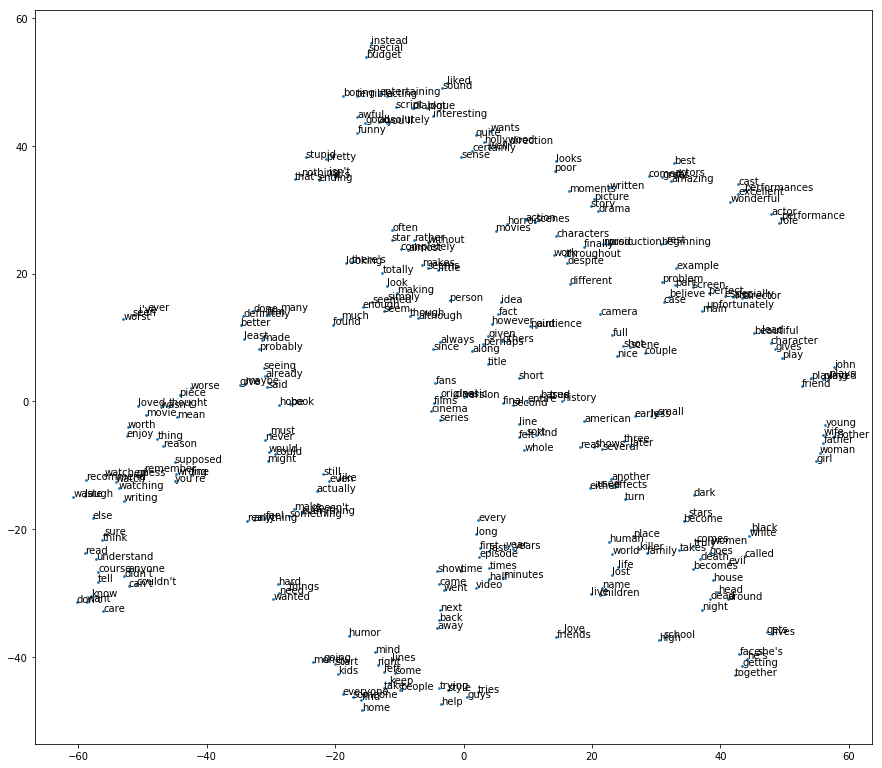

In [9]:
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

stpwds = set(stopwords.words('english'))

n_plot = 500
mft = [vocab_inv[elt] for elt in range(1,n_plot+1)]

# exclude stopwords and punctuation
keep_idxs = [idx for idx,elt in enumerate(mft) if len(elt)>3 and elt not in stpwds]
mft = [mft[idx] for idx in keep_idxs]
keep_ints = [list(range(1,n_plot+1))[idx] for idx in keep_idxs]
Wt_freq = Wt[keep_ints,]

my_pca = PCA(n_components=10)
my_tsne = TSNE(n_components=2,perplexity=5)

my_pca_fit = my_pca.fit_transform(Wt_freq)
my_tsne_fit = my_tsne.fit_transform(my_pca_fit)

fig, ax = plt.subplots()
ax.scatter(my_tsne_fit[:,0], my_tsne_fit[:,1],s=3)
for x,y,token in zip(my_tsne_fit[:,0],my_tsne_fit[:,1],mft):
    ax.annotate(token, xy=(x,y), size=10)

fig.set_size_inches(15,13.5)
fig.savefig('./plots/word_embeddings.pdf',dpi=300)
fig.show()

We can see that the groupings make sense. For instance, we have `year`, `years`, `minutes`, `last`, `first`, `long`, `times`, `time`, `episode` all clustered together.

### Document vectors
Recall that our corpus is made of the 25K movie reviews in the training set of the IMDB dataset. In that set, the first 12,500 reviews are negative and the last 12,500 are positive. Let's load the document vectors, select some corresponding to positive/negative reviews, and see whether our vectors capture polarity.
We also define a quick helper function to display the content of the documents.

In [15]:
Wd = np.load('./weights/doc_vecs.npy')

my_pca = PCA(n_components=2)
my_tsne = TSNE(n_components=2,perplexity=10)

n_per_cat = 50

Wd_plot = np.concatenate([Wd[:n_per_cat,],Wd[-n_per_cat:,]],axis=0)

my_pca_fit = my_pca.fit_transform(Wd_plot)
my_tsne_fit = my_tsne.fit_transform(my_pca_fit)

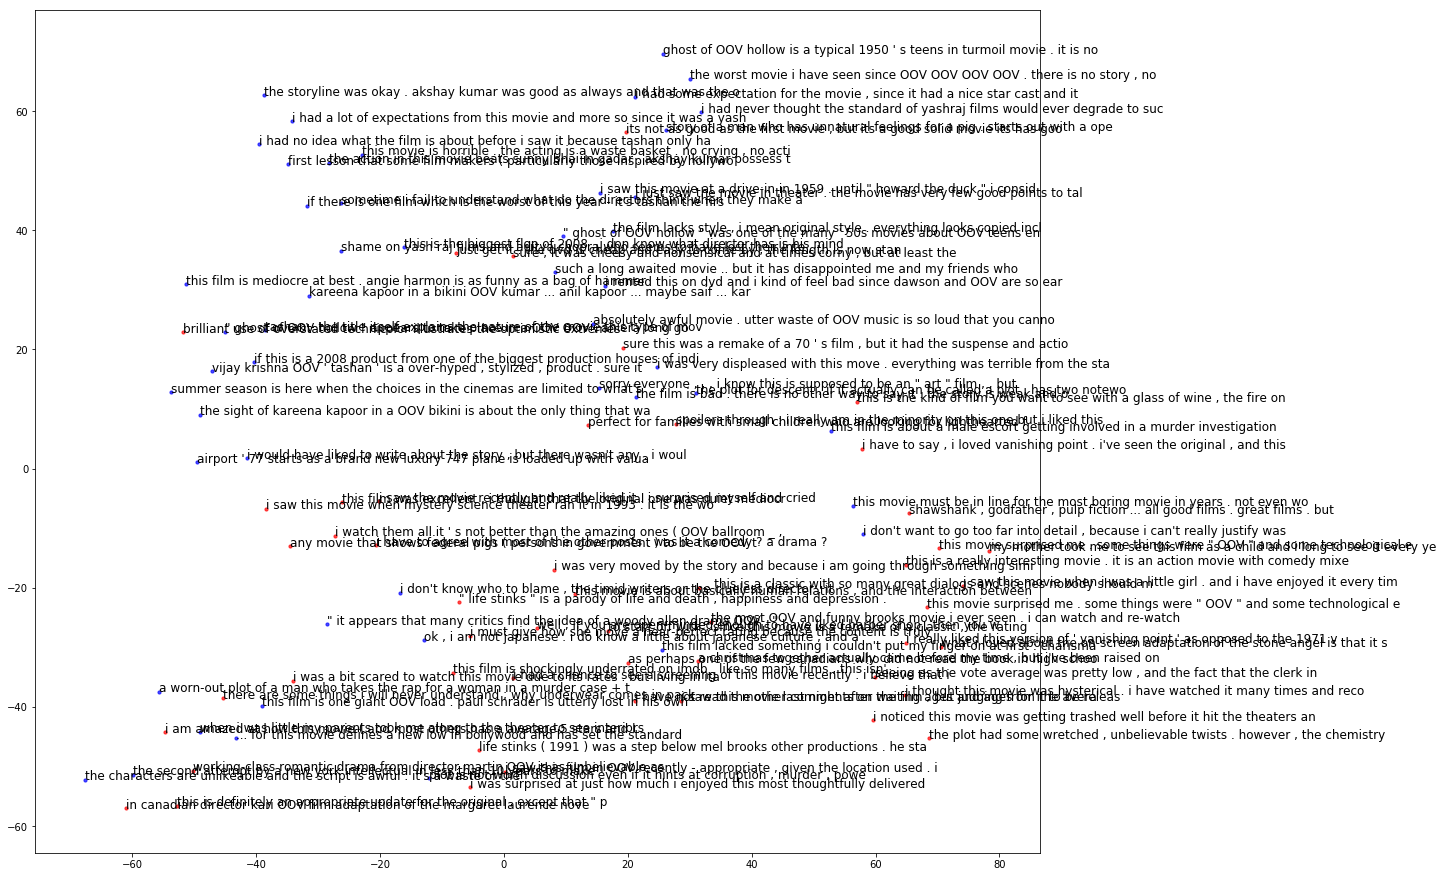

In [16]:
def convert_nl(doc,maxchar):
    return ' '.join([vocab_inv[elt] if elt in vocab_inv else 'OOV' for elt in doc])[:maxchar]

my_cols = ['blue','red']
labels = [0]*n_per_cat + [1]*n_per_cat
docs_plot = docs[:n_per_cat] + docs[-n_per_cat:]

fig, ax = plt.subplots()
for idx in range(my_tsne_fit.shape[0]):
    x = my_tsne_fit[idx,0]
    y = my_tsne_fit[idx,1]
    ax.scatter(x,y,s=10,c=my_cols[labels[idx]],alpha=0.7)
    ax.annotate(convert_nl(docs_plot[idx],75),(x,y),size=12)

fig.set_size_inches(18,15.5)
fig.savefig('./plots/doc_embeddings.pdf',dpi=300)
fig.show()

Even though the separation is not perfect, there seem to be more negative reviews on top/left and more positive reviews at the bottom/right. Of course, we cannot expect polarity to be perfectly captured, since the document vectors were learned in a completely unsupervised manner. The kind of similarly that we expect the vectors to capture is more some sort of semantic similarity (topics). And indeed, we can see (with difficulty, but it's better in the PDF version of the plot) that, e.g., reviews about Bollywood movies are relatively close to each other (`akshay kumar`, `tashan`, `karena kapoor`, `vijay krishna`, `yash raj`).
Let's now pursue our inspection by querying the training corpus for the most similar documents to a given query.

## Queries over documents

In [17]:
def get_most_similar_docs(vec,n_return,maxchar):
    sims = []
    for idx in range(Wd.shape[0]):
        sim = my_cos_similarity(vec,Wd[idx,])
        sims.append(sim)
    
    idxs_sorted_sims = list(np.argsort(-np.array(sims)))[:n_return] # negate to sort in decreasing order
    for idx in idxs_sorted_sims:
        print('* * * sim = ',sims[idx],'* * *')
        print('idx=',idx)
        print(convert_nl(docs[idx],maxchar))

### Known query
Let's first use a document from our training corpus as query (a review about a Bollywood movie), and inspect its five nearest neighbors in the document embedding space. 

In [18]:
vec = Wd[23,]
get_most_similar_docs(vec,5,300)

* * * sim =  1.0 * * *
idx= 23
vijay krishna OOV ' tashan ' is a over-hyped , stylized , product . sure its a one of the most stylish films , but when it comes to content , even the masses will reject this one . why ? the films script is as amateur as a 2 year old baby . script is king , without a good script even the greatest di
* * * sim =  0.8213 * * *
idx= 21574
a very enjoyable film that features characters who do bad things and who let emotions like anger and a desire for vengeance bubble over . the cast is very good , there's plenty of action , and stewart gets the girl and his revenge ( with a twist ) in the end . i've seen this film several times , and
* * * sim =  0.7852 * * *
idx= 46
the sight of kareena kapoor in a OOV bikini is about the only thing that wakes you up from your sleep while watching tashan  the OOV , mind-numbing new film at the cinemas this weekend . bad films are bad films and we see some every week , but tashan is not just a bad film , it's a terrible fil

Of course, the query itself is the top result. Among the other four nearest neighbors, we do find at position 2 another Bollywood movie! The result at position 3 is also about a foreign movie (Chinese apparently). Not sure whether this is related to Bollywood though.
To sum up, we did capture a relevant result within the 4 nearest neighbors of our query, which is not bad over a corpus of 25K documents. But of course, results are far from perfect. Ideally, we should retrieve more Bollywood-related reviews in the results.

### Never-seen query (inference)
Let's now continue by using as query a totally new document. Of course, we don't have a representation for that new document because we haven't seen it during training. To get a vector for it, we need to run our model in *inference* mode. To do that, we initialize the new document vector randomly, sample windows from it and negative examples, and pass all of that to the trained model. We compute the loss and the gradients, and use them to update the document vector. We repeat the process over several 'mini-epochs'. This is implemented in the function below.

In [19]:
def inference_step(doc_int,n_steps,lr_0,decay,max_win_size):

    n_its = 0
    infer_vec = np.random.normal(size=(d,))

    with tqdm(total=n_steps,unit_scale=True,postfix={'loss':0.0,'lr':lr_0},ncols=600) as pbar:
        for step in range(n_steps):
            step_loss = 0

            windows = [list(elt) for elt in list(get_windows(doc_int,max_win_size))]
            for i,w in enumerate(windows):

                lr = lr_0 * 1/(1+decay*n_its)
                n_its += 1

                target = w[int(len(w)/2)] # elt at the center
                pos = w
                del pos[int(len(w)/2)] # all elts but the center one

                negs = list(np.random.choice(token_ints,size=n_negs,p=neg_distr))

                prods = compute_dot_products(pos,negs,infer_vec)
                prodpos = prods[0:len(pos),]
                prodnegs = prods[len(pos):(len(pos)+len(negs)),]

                _,_,partial_target = compute_gradients(pos,negs,infer_vec,prodpos,prodnegs)

                infer_vec -= lr * partial_target

                step_loss += compute_loss(prodpos,prodnegs)

            loss_display = round(step_loss/len(windows),4)
            if step == 0:
                print('loss after step 1:',loss_display) # tqdm will only display the final loss

            pbar.set_postfix({'loss':loss_display,'lr':lr})
            pbar.update(1)

    return infer_vec

Let's first sanity check our inference mode by using it with the same query as before (#23 from the training set) and verifying that the inferred vector is close to the already existing vector.

In [20]:
vec = Wd[23,]
doc_int = docs[23]
infer_vec = inference_step(doc_int,n_steps=20,lr_0=0.01,decay=0.0005,max_win_size=5)

print(my_cos_similarity(vec,infer_vec))
print(my_cos_similarity(vec,np.random.normal(size=(d,))))

loss after step 1: 8.8431

0.544
-0.3359


<img style="float: left;" src="https://raw.githubusercontent.com/Tixierae/deep_learning_NLP/master/skipgram/images/tqdm_3.png" alt="" width="700"/>

Granted, the inferred vector is not as close as the trained one we would have wanted it to be, but still, it is close. And much closer than after random initialization. Also, we can see that we decrease the loss quite efficiently (from 7.2 to 3.84 after 20 steps). All of this tends to suggest that our inference mode implementation works.
Let's now try to use it on new queries and see what we get.

In [24]:
doc_nl = 'Please , please make me forget . This is probably the worst \
movie ever made , and without a doubt the worst film I have ever had the misfortune to \
watch .'
doc_int = [vocab[elt] if elt in vocab else 0 for elt in doc_nl.lower().split()]

infer_vec = inference_step(doc_int,n_steps=20,lr_0=0.01,decay=0.0005,max_win_size=5)

get_most_similar_docs(infer_vec,5,300)

loss after step 1: 8.7691

* * * sim =  0.8091 * * *
idx= 1305
unless somebody OOV me , i really have no idea what this movie is about . it looks like a picture with a message but it ´ s far from it . this movie tells pointless story of a new york press agent and about his problems . and , that ´ s basically all . when that agent is played by pacino , one must 
* * * sim =  0.7972 * * *
idx= 815
i have yet to read a negative professional review of this movie . i guess i must have missed something . the beginning is intriguing , the three main characters meet late at night in an otherwise empty bar and entertain each other with invented stories . that's the best part . after the three go the
* * * sim =  0.7912 * * *
idx= 10349
steve carpenter cannot make horror movies . first of all , the casting was very wrong for this movie . the only decent part was the hot brown haired girl from buffy the vampire slayer . this movies has no gore ( usually a key ingredient to a horror movie ) , no a

<img style="float: left;" src="https://raw.githubusercontent.com/Tixierae/deep_learning_NLP/master/skipgram/images/tqdm_2.png" alt="" width="700"/>

OK, it's not perfect, but the results are somewhat relevant. Let's try now with a positive query.

In [26]:
doc_nl = "What a masterpiece ! ! ! ! brilliant , best film ever made ! Virtually flawless \
. You must experience the grace of this movie . I will buy the DVD for sure ."

doc_int = [vocab[elt] if elt in vocab else 0 for elt in doc_nl.lower().split()]

infer_vec = inference_step(doc_int,n_steps=20,lr_0=0.01,decay=0.0005,max_win_size=5)

get_most_similar_docs(infer_vec,5,300)

loss after step 1: 9.8854

* * * sim =  0.8504 * * *
idx= 837
waiting to go inside the OOV with tickets in my hand , i expected an interesting sci-fi fantasy movie which could finally feed my appetite of movies regarding OOV , instead i went disappointed by each aspect of it , once more proving that stunning special effects can't help a boring plot , which by 
* * * sim =  0.8171 * * *
idx= 21170
ok heres what i say : the movie was excellent . i am a huge nancy fan and i have read all OOV original books and i went on to read more . i am now on 96 . beware of villains giving this movie a lower grade than it should have . all clues point to a wonderful movie ! i loved the whole thing . so what
* * * sim =  0.7948 * * *
idx= 13997
i absolutely loved this movie when i was a kid . i cried every time i watched it . it wasn't weird to me . i totally identified with the characters . i would love to see it again ( and hope i wont be disappointed ! ) . pufnstuf rocks ! ! ! i was really drawn in 

<img style="float: left;" src="https://raw.githubusercontent.com/Tixierae/deep_learning_NLP/master/skipgram/images/tqdm_4.png" alt="" width="700"/>

Again, the results are not perfect. Two reviews, including the first one, are negative. But the other results (2, 3 and 5) are highly relevant. They are, like the query, highly positive, elogious reviews.

## Word and document vectors
Word and document vectors live in the same space, so they can be visualized together. Let's inspect what we have.

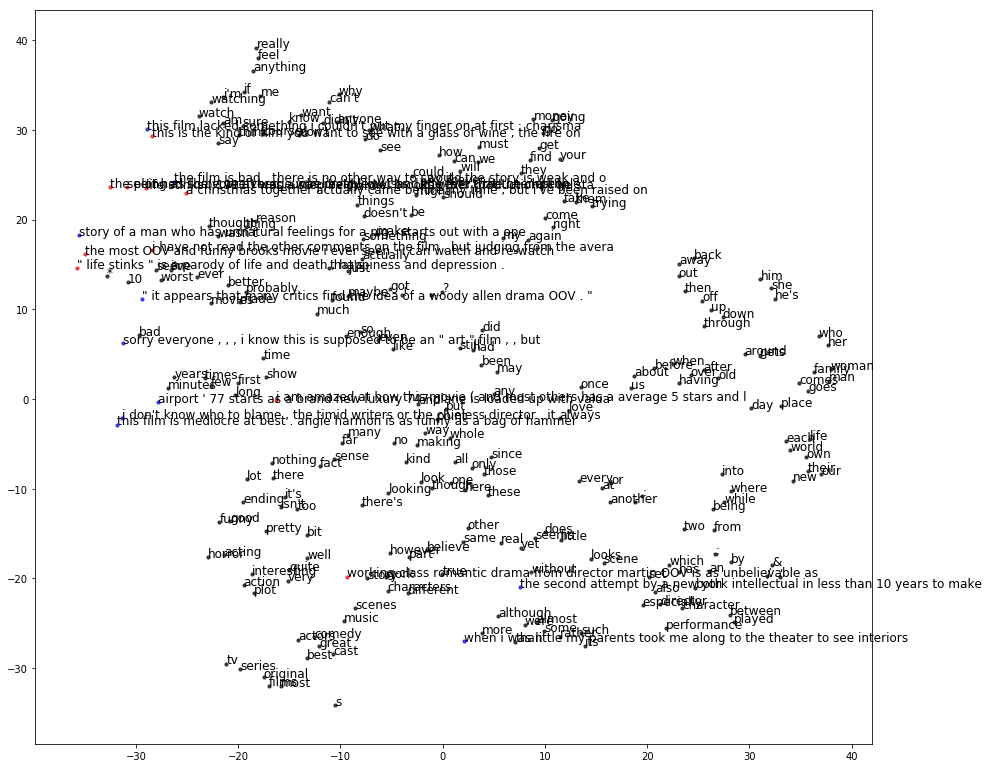

In [30]:
n_per_cat = 10
docs_plot = docs[:n_per_cat] + docs[-n_per_cat:]
word_docs = [elt for sublist in docs_plot for elt in sublist] # words appearing in the docs
word_docs = list(set(word_docs)) # uniquify
word_docs = [elt for elt in word_docs if elt<300 and elt>30] # most frequent/not stopwords and OOV

# now the vectors
Wd_plot_new = np.concatenate([Wd[:n_per_cat,],Wd[-n_per_cat:,]],axis=0)
Wt_plot = Wt[word_docs,]
W_plot = np.concatenate([Wt_plot,Wd_plot_new],axis=0)

my_cols = ['black','blue','red']
labels = [0]*len(word_docs) + [1]*n_per_cat + [2]*n_per_cat
docs_plot = word_docs + docs_plot

my_pca = PCA(n_components=10)
my_tsne = TSNE(n_components=2,perplexity=10)

my_pca_fit = my_pca.fit_transform(W_plot)
my_tsne_fit = my_tsne.fit_transform(my_pca_fit)

fig, ax = plt.subplots()
for idx in range(my_tsne_fit.shape[0]):
    x = my_tsne_fit[idx,0]
    y = my_tsne_fit[idx,1]
    ax.scatter(x,y,s=10,c=my_cols[labels[idx]],alpha=0.7)
    if idx<len(word_docs):
        ax.annotate(vocab_inv[docs_plot[idx]],(x,y),size=12) # word
    else:
        ax.annotate(convert_nl(docs_plot[idx],75),(x,y),size=12) # doc
    
fig.set_size_inches(15,13.5)
fig.savefig('./plots/worddoc_embeddings.pdf',dpi=300)
fig.show()

# Thank you for your interest!
If you found any error or have any suggestion for improvement, you are welcome to file an issue on GitHub or submit a PR. For any other inquiry, you may also contact me via `antoine.tixier-1` AT `colorado.edu`.
If you use some of the code in this repository in your own work, please cite:
* bibtex:
```
@article{tixier2018notes,
  title={Notes on Deep Learning for NLP},
  author={Tixier, Antoine J-P},
  journal={arXiv preprint arXiv:1808.09772},
  year={2018}
}
```
* plain text:
```
Tixier, Antoine J-P. "Notes on Deep Learning for NLP." arXiv preprint arXiv:1808.09772 (2018).
```